In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:2')
    dtype = torch.cuda.FloatTensor

elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)

cuda:2


In [3]:
inception_model = InceptionV3_Pool3(device=device)
inception_model.eval()

inception_preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    # If your patches are in [-1,1], shift to [0,1] first, then normalize:
    transforms.Lambda(lambda t: (t + 1) / 2 if t.min() < 0 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

1 variantes, 8 niveaux chacune.


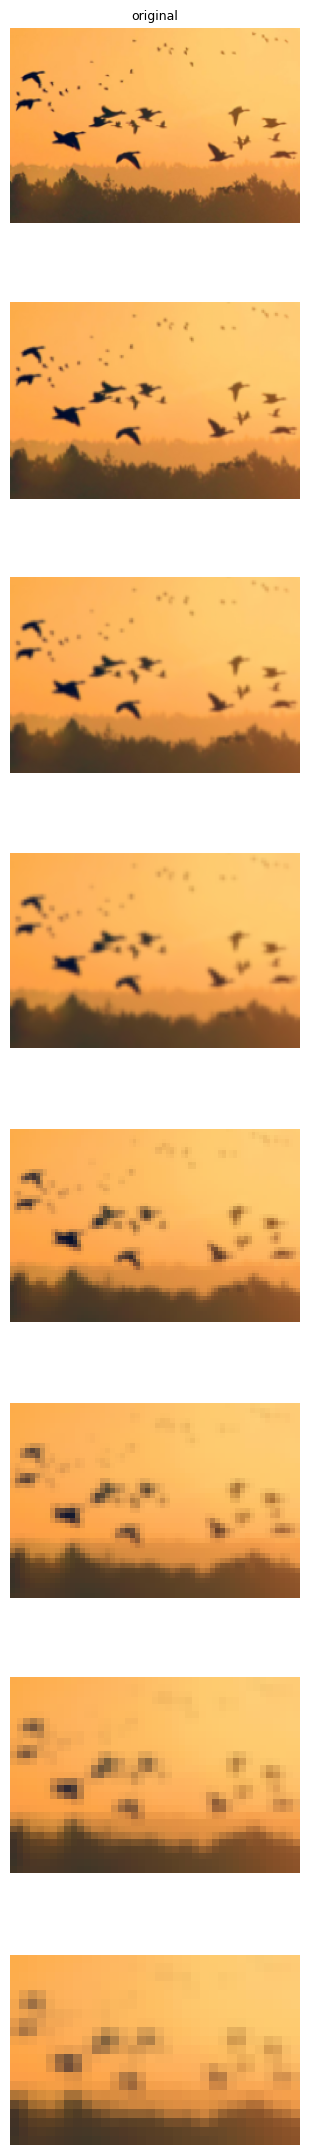

In [4]:
"""
SinGAN data-augmentation helper (torchvision.GaussianBlur)
──────────────────────────────────────────────────────────
• Produit l’image originale + N_AUG variantes aléatoires.
• Augmentations possibles :
      – pad réflectif + rotation aléatoire (sans bordures noires)
      – ColorJitter
• Chaque variante finit en 3×H×W, valeurs ∈ [-1, 1].
• Construit pour chacune la pyramide d’échelles façon SinGAN.
"""


import random, torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T

# ------------------------------------------------------------
# 1. Config
# ------------------------------------------------------------
IMG_PATH   = Path("images/birds.png")             # image de référence
MAX_DIM    = 250        # côté le plus long après resize initial
MIN_DIM    = 25         # côté mini à l’échelle la plus coarse
RATIO      = 4/3      # facteur de downscale entre niveaux

N_AUG      = 0          # nombre de variantes à générer
MAX_ROT    = 5         # rotation ±MAX_ROT°
PAD_RATIO  = 0.20       # pad(reflect) = PAD_RATIO × taille

JITTER     = dict(brightness=0.25,
                  contrast=0.25,
                  saturation=0.25,
                  hue=0.1)

SEED       = 1       # fixer pour reproductibilité

# ------------------------------------------------------------
# 2. Bloc d’augmentation
# ------------------------------------------------------------
class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.jitter  = T.ColorJitter(**JITTER)
        
    @torch.no_grad()
    def forward(self, x):
        # x : 3×H×W ∈ [-1,1]
        C, H, W = x.shape

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))

        # ColorJitter
        x = self.jitter((x+1)/2) * 2 - 1

        return x.clamp(-1, 1)


torch.manual_seed(SEED) 
random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]


augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# ------------------------------------------------------------
# 5. Pyramides SinGAN
# ------------------------------------------------------------
def build_pyramid(img):
    levels = [img.unsqueeze(0)]              # fine → coarse (déjà sur device)
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} niveaux chacune.")

# ------------------------------------------------------------
# 6. (Optionnel) Visualisation grille
# ------------------------------------------------------------
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    
    # Handle case with a single column (cols == 1) or multiple columns
    if cols == 1:
        fig, axes = plt.subplots(rows, 1, figsize=(3.2, 2.8 * rows))
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 2.8 * rows))
    
    # In case of a single column, axes is a 1D array, not a 2D array
    for r in range(rows):
        for c in range(cols):
            # Handle the case where there's only one column (axes is not a 2D array)
            if cols == 1:
                ax = axes[r]
            else:
                ax = axes[r, c]
            
            # Process the image
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1, 2, 0) + 1) / 2
            ax.imshow(img_np.clamp(0, 1))
            
            # Set the title for the top row
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            
            # Hide the axis ticks
            ax.axis('off')
    
    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

# Décommentez pour vérifier visuellement
show_grid(pyramids)


In [5]:
for x in pyramids[0] : 
    print(x.shape)
    print(x.device)

torch.Size([1, 3, 168, 249])
cuda:2
torch.Size([1, 3, 126, 186])
cuda:2
torch.Size([1, 3, 94, 139])
cuda:2
torch.Size([1, 3, 70, 104])
cuda:2
torch.Size([1, 3, 52, 78])
cuda:2
torch.Size([1, 3, 39, 58])
cuda:2
torch.Size([1, 3, 29, 43])
cuda:2
torch.Size([1, 3, 21, 32])
cuda:2


In [6]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [7]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [11]:
hidden_lowest_dim = 32
Genarators = []
N = len(pyramids[0])

for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   

for gen in Genarators : 
     print(gen.n_hidden)



128
64
64
64
64
32
32
32


+ Boucle d'entrainement 

it scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 | it 0] 
[scale 7 | it 0]  LR = 1.00e-04

 mean lost 50 iter 1.7010

ratio_loss = 184172368.0496


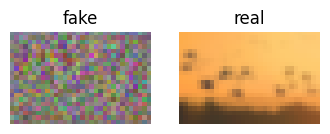

it scale 7:  20%|██        | 400/2000 [00:42<02:35, 10.29it/s]

[scale 7 | it 400] 
[scale 7 | it 400]  LR = 1.00e-04

 mean lost 50 iter 1.6267

ratio_loss = 163899326.3245


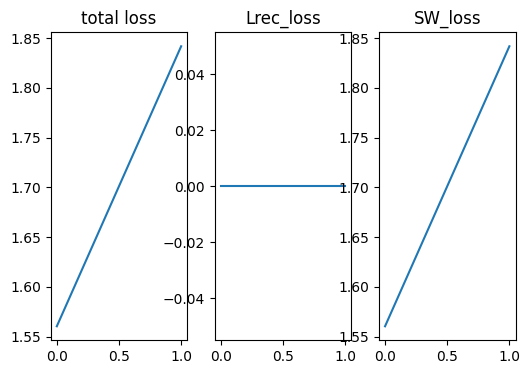

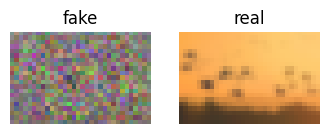

it scale 7:  40%|████      | 800/2000 [01:24<01:45, 11.33it/s]

[scale 7 | it 800] 
[scale 7 | it 800]  LR = 1.00e-04

 mean lost 50 iter 1.6364

ratio_loss = 170503067.9703


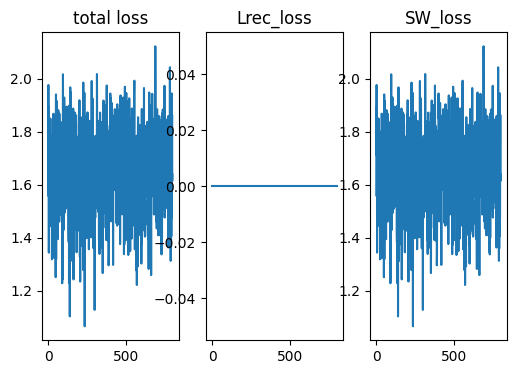

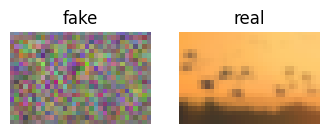

it scale 7:  60%|██████    | 1200/2000 [02:07<01:33,  8.60it/s]

[scale 7 | it 1200] 
[scale 7 | it 1200]  LR = 1.00e-04

 mean lost 50 iter 1.6655

ratio_loss = 167757892.6086


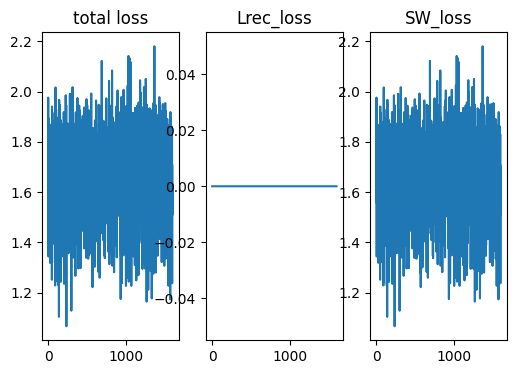

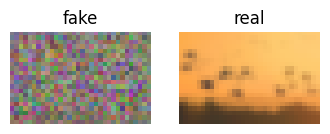

KeyboardInterrupt: 

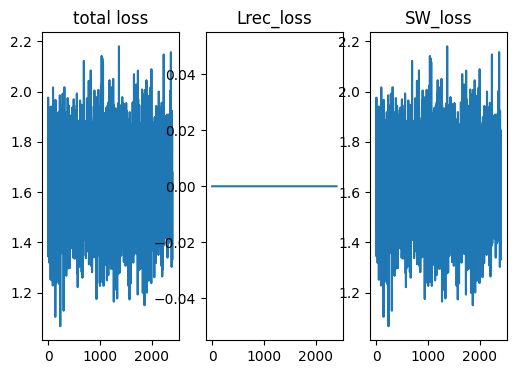

In [12]:
torch.random.manual_seed(1)

# params
lambda_gp    = 10
lr             = 1e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
base_iter   = 2000 # github
alpha_rec      = 0 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
lamda_swd = 10

for G in Genarators:
    G.apply(weights_init)


# reset des optim.
optimizer_G = []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G = []

step_size   = 20000        # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star   = torch.randn_like(pyramids[0][-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)

    z  = torch.randn_like(img) * sigma_n[N - 1]
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        z = torch.randn_like(img_up) * sigma_n[s]

        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    xk_real = pyramids[0][current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    # itérations par scale
    iter_per_scale = base_iter
    
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):
        idx = torch.randint(0, 1, (b,))
        xk_real = torch.stack([pyramids[i][current_res].squeeze(0) for i in idx]).to(device)
        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res,b)

        
        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            
            # Extract features from fake images (using Inception)
            fake_preprocessed = torch.zeros((b, 3, 299, 299)).to(device)
            real_preprocessed = torch.zeros((b, 3, 299, 299)).to(device)
            for i in range(b):
                fake_preprocessed[i] = inception_preprocess(fake[i])
                real_preprocessed[i] = inception_preprocess(xk_real[i])
                
                
            # Get the features from InceptionV3
            with torch.no_grad():
                fake_inception_features = inception_model(fake_preprocessed)
                real_inception_features = inception_model(real_preprocessed)
                
            # Calculate Sliced Wasserstein Loss on features
            swd = sliced_wasserstein_distance(preprocess_features(real_inception_features), preprocess_features(fake_inception_features), num_projections=128)
            Sw_loss = lamda_swd * swd
                
            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star.repeat(b,1,1,1)                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                up_fixed = up_fixed.repeat(b,1,1,1)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec_loss = alpha_rec * F.mse_loss(rec_out, xk_real)
            total_loss = Lrec_loss + Sw_loss
            (total_loss).backward()
            total_loss_list.append(total_loss.item())
            Lrec_loss_list.append(Lrec_loss.item())
            Sw_loss_list.append(Sw_loss.item())
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 400 == 0 or it==iter_per_scale-1):
            ratio_loss = abs(Sw_loss.item())/(abs(Lrec_loss.item()) + 1e-8)

            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            print(f"[scale {current_res} | it {it}] ")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")
            print(f'\n mean lost 50 iter {np.mean(total_loss_list[-50:]):.4f}')
            print(f"\nratio_loss = {ratio_loss:.4f}")
            
        

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
                
                plt.figure(figsize=(6,4))
                plt.subplot(1,3,1)
                plt.plot(total_loss_list)
                plt.title("total loss")
                plt.subplot(1,3,2)
                plt.plot(Lrec_loss_list)
                plt.title("Lrec_loss")
                plt.subplot(1,3,3)
                plt.plot(Sw_loss_list)
                plt.title("SW_loss")
    
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake[0].detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    
    plt.show()

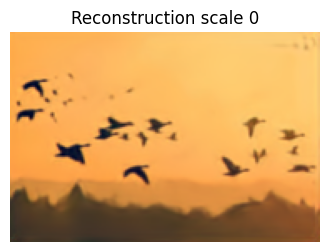

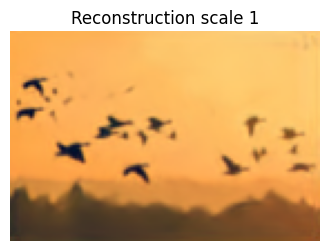

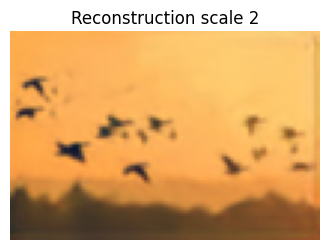

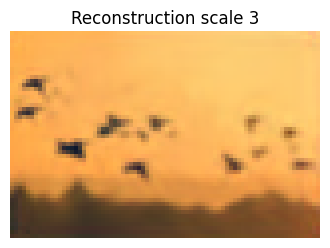

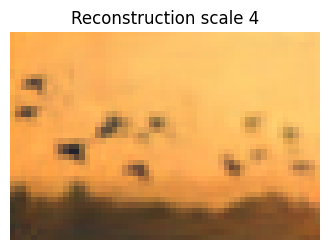

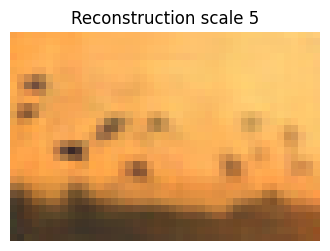

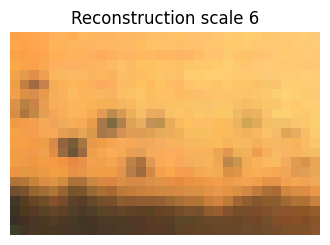

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])

SAVING GENERATORS AND NECESSARY PARAMS

In [11]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "sw_patch_big_2" 
image_name = "oiseau"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "r"                 : float(4/3),
        "lr"             : lr,
        "betas"          : betas,
        "patch_size": [10,20],
        "n_Generator"    : n_Generator,
        "base_iter" : base_iter,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "lambda_sw" : lamda_swd,
        "stride" : [5,10],
        "comment"        : "Sin Gan avec de la data aug sur l'image réele. + swd trainning on multiple patch_size",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/oiseau/sw_patch_big_2/generators.pt
Description créée           -> models/oiseau/sw_patch_big_2/Description.txt
sigma_n sauvegardé          -> models/oiseau/sw_patch_big_2/sigma_n.json
z_star sauvegardé           -> models/oiseau/sw_patch_big_2/z_star.pt
